# Reimplementation of _Topic Modeling with Wasserstein Autoencoders_ by Feng Nan et al. (2019)

#### Group Members: Aryaan Khan, Yuhang Cui, and Raymond Lee

### Import Libraries

In [1]:
import re
import nltk
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import fetch_20newsgroups
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import TfidfVectorizer

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aryaankhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aryaankhan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Load the Dataset

In [2]:
# Load the 20 Newsgroups dataset
categories = None  # You can specify categories to limit the dataset
data = fetch_20newsgroups(subset='all', categories=categories, remove=('headers', 'footers', 'quotes'))

# Accessing the text data
texts = data.data

### Preprocess the Data

In [3]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    
    # Tokenization
    tokens = text.split()
    
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Re-create document from tokens
    return ' '.join(tokens)

In [4]:
# Apply preprocessing to each document in the dataset
processed_texts = [preprocess_text(text) for text in texts]

# Example of a processed text
print(processed_texts[0])

sure bashers pen fan pretty confused lack kind post recent pen massacre devil actually bit puzzled bit relieved however going put end nonpittsburghers relief bit praise pen man killing devil worse thought jagr showed much better regular season stats also lot fo fun watch playoff bowman let jagr lot fun next couple game since pen going beat pulp jersey anyway disappointed see islander lose final regular season game pen rule


In [5]:
# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)  # Limiting to 1000 features
tfidf_matrix = vectorizer.fit_transform(processed_texts)

# Review the shape of the TF-IDF matrix
print(tfidf_matrix.shape)


(18846, 1000)


### Define an Encoder and Decoder

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.linear = nn.Linear(input_dim, 128)
        self.latent = nn.Linear(128, latent_dim)
    
    def forward(self, x):
        x = torch.relu(self.linear(x))
        z = self.latent(x)
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.linear = nn.Linear(latent_dim, 128)
        self.out = nn.Linear(128, output_dim)
    
    def forward(self, z):
        z = torch.relu(self.linear(z))
        x_reconstructed = torch.sigmoid(self.out(z))  # Use sigmoid for outputs between 0 and 1, typical for normalized data
        return x_reconstructed

### Define the Wasserstein Autoencoder Model

In [7]:
class WassersteinAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(WassersteinAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, z

    def compute_loss(self, x, x_reconstructed, z, device='cpu'):
        # Reconstruction loss
        recon_loss = nn.MSELoss()(x_reconstructed, x)
        
        # Wasserstein loss: Here you can try different formulations. For example:
        # Adjusting to only calculate the mean difference squared
        z_prior = torch.randn_like(z).to(device)
        wasserstein_loss = torch.mean((z - z_prior) ** 2)
        
        # Combine losses
        return recon_loss + 0.1 * wasserstein_loss  # Adding a weight factor to balance losses


### Train the WAE Model

In [8]:
def train_model(model, dataloader, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (data,) in enumerate(dataloader):
            data = data.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            x_reconstructed, z = model(data)
            
            # Loss computation
            loss = model.compute_loss(data, x_reconstructed, z, device)
            
            # Backpropagation
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f'Epoch {epoch+1}, Loss: {total_loss / len(dataloader)}')

In [9]:
# Define the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f'Using device: {device}')

# Assuming 'tfidf_matrix' is already defined and is your TF-IDF sparse matrix
input_dim = tfidf_matrix.shape[1]  # Feature size from TF-IDF

# Define the model
latent_dim = 20  # This is a parameter you can tweak depending on the complexity desired in the latent space
model = WassersteinAE(input_dim, latent_dim).to(device)  # Model is sent to appropriate device

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Prepare data for PyTorch DataLoader
tfidf_tensor = torch.tensor(tfidf_matrix.toarray()).float()
dataset = TensorDataset(tfidf_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Start training
train_model(model, dataloader, optimizer, num_epochs=5)

# Save the model
torch.save(model.state_dict(), 'wasserstein_ae.pth')

# Load the model (for future use)
model.load_state_dict(torch.load('wasserstein_ae.pth'))


Using device: mps
Epoch 1, Loss: 0.12987087540707346
Epoch 2, Loss: 0.10197144524525788
Epoch 3, Loss: 0.10152905489933693
Epoch 4, Loss: 0.10064950274713969
Epoch 5, Loss: 0.10078732197062444


<All keys matched successfully>

### Evaluate the Model

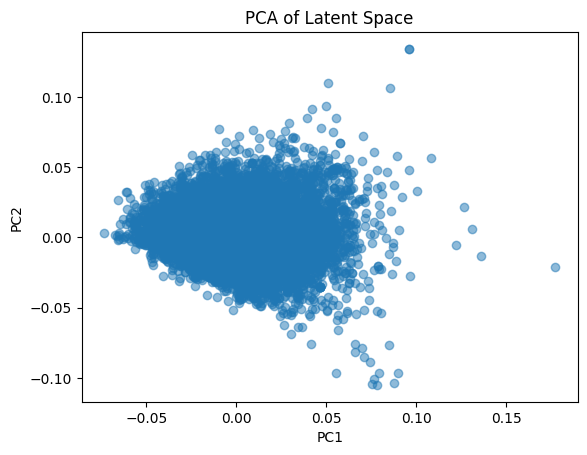

In [10]:
# Assuming 'model' is already trained and 'tfidf_matrix' is available
model.eval()

# Extract the latent representations
latent_variables = []
for i in range(tfidf_matrix.shape[0]):
    data_point = torch.tensor(tfidf_matrix[i].toarray()).float().to(device)
    _, z = model(data_point)
    latent_variables.append(z.detach().cpu().numpy())

latent_variables = np.array(latent_variables).squeeze()

# Use PCA for dimensionality reduction for visualization
pca = PCA(n_components=2)
reduced_latent = pca.fit_transform(latent_variables)

# Plot
plt.scatter(reduced_latent[:, 0], reduced_latent[:, 1], alpha=0.5)
plt.title('PCA of Latent Space')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# Cluster the latent space to identify topics
num_topics = 10
kmeans = KMeans(n_clusters=num_topics, random_state=0).fit(latent_variables)
labels = kmeans.labels_

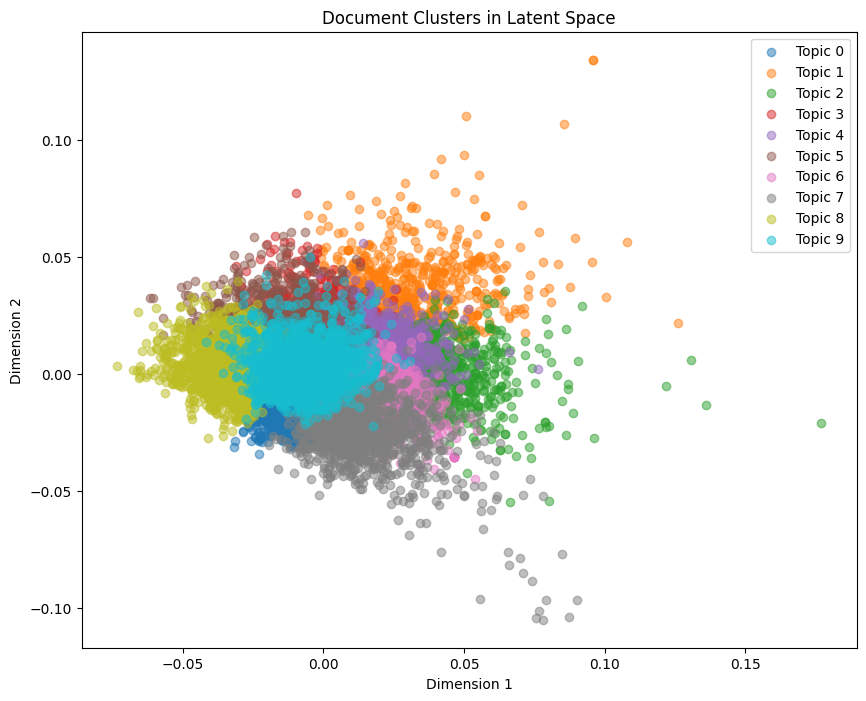

In [11]:
plt.figure(figsize=(10, 8))
for i in range(num_topics):
    plt.scatter(reduced_latent[labels == i, 0], reduced_latent[labels == i, 1], label=f'Topic {i}', alpha=0.5)
plt.title('Document Clusters in Latent Space')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

In [14]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.matutils import Sparse2Corpus

words = vectorizer.get_feature_names_out()  # For sklearn versions 0.24 and later use get_feature_names_out()

top_words_per_topic = []
for i in range(num_topics):  # 'num_topics' is the number of clusters you decided in KMeans
    # Calculate mean TF-IDF score for words in documents of each cluster
    topic_mean = np.array(tfidf_matrix[labels == i].mean(axis=0)).flatten()
    
    # Get indices of top 10 words for this topic
    top_indices = topic_mean.argsort()[-10:][::-1]  # Change 10 to another number if you want more or fewer words
    top_features = [words[index] for index in top_indices]
    top_words_per_topic.append(top_features)

# Example output
print("Top words per topic:")
for i, words in enumerate(top_words_per_topic):
    print(f"Topic {i}: {words}")


Top words per topic:
Topic 0: ['would', 'one', 'dont', 'think', 'people', 'know', 'get', 'like', 'time', 'right']
Topic 1: ['game', 'jewish', 'deleted', 'thanks', 'armenian', 'say', 'test', 'ax', 'list', 'im']
Topic 2: ['key', 'would', 'mhz', 'muslim', 'one', 'going', 'good', 'window', 'try', 'use']
Topic 3: ['would', 'game', 'get', 'like', 'know', 'one', 'im', 'people', 'dont', 'time']
Topic 4: ['drive', 'dont', 'one', 'god', 'jesus', 'mac', 'mb', 'know', 'say', 'system']
Topic 5: ['thanks', 'anyone', 'please', 'email', 'know', 'one', 'would', 'im', 'get', 'new']
Topic 6: ['one', 'window', 'would', 'dont', 'file', 'please', 'way', 'know', 'god', 'make']
Topic 7: ['player', 'better', 'one', 'team', 'could', 'would', 'think', 'like', 'good', 'dont']
Topic 8: ['would', 'one', 'get', 'like', 'people', 'know', 'dont', 'time', 'think', 'problem']
Topic 9: ['would', 'thanks', 'driver', 'anyone', 'one', 'like', 'could', 'ive', 'window', 'please']


In [15]:
# Assuming `tfidf_vectorizer` is your TfidfVectorizer object and `tfidf_matrix` is your vectorized data
words = vectorizer.get_feature_names_out()
dictionary = Dictionary([words])
corpus = Sparse2Corpus(tfidf_matrix, documents_columns=False)

# Compute top words for each topic
top_words_per_topic = []
for i in range(num_topics):
    topic_terms = np.array(tfidf_matrix[labels == i].mean(axis=0)).reshape(-1)
    top_terms = topic_terms.argsort()[-10:][::-1]  # adjust number of top words here
    top_words = [words[j] for j in top_terms]
    top_words_per_topic.append(top_words)

# Compute coherence
cm = CoherenceModel(topics=top_words_per_topic, corpus=corpus, dictionary=dictionary, coherence='u_mass')
coherence = cm.get_coherence()  # get coherence value
print('Coherence Score:', coherence)

Coherence Score: -1.83660544894691
